# OPPORTUNITY UNITS (OUs)

In this notebook, we use the 8 detected cartographic areas of opportunity and correlate them with the stops performed by the participants (to do the actions). We obtain the basic statistics:  the number of stops inside each area, the average duration of the stops, etc.

We also cross-referenced the number of stops that belong to both a cluster (weighted k-means) and one of the areas (AOU).


In [18]:
from gpxcsv import gpxtolist
import pandas as pd
import networkx as nx
import osmnx as ox


import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from folium import Map
from folium.plugins import HeatMap, HeatMapWithTime
import utm
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from shapely.geometry import Point, LineString, Polygon
import folium

from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from gap_statistic import OptimalK

from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
from matplotlib.patches import Rectangle

#%matplotlib notebook
#matplotlib inline
#ox.config(use_cache=True, log_console=True)
#ox.__version__





In [19]:
def map_network(latitude, longitude, dist):
    """" Function that creates a map of the urban network in a given radius around a gps location.
    
    Input:
        - latitude and longitude (GPS coordinates)
        - dist: distance (radius) from which the network is constructed
        
    Output:
        - The figure and the axes.
        
    """
    
    G = ox.graph_from_point((latitude, longitude), dist, network_type='all')   # Create the graph from lat and lon
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.8, node_size=0)
    
    #for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():     # Name of the street
        #c = edge['geometry'].centroid
        #text = edge['name']
        #ax.annotate(text, (c.x, c.y), c='w')       
 
    return fig, ax


def map_network2(lat1,lon1,lat2,lon2,lat3,lon3,lat4,lon4):
    """" Function that creates a map of the urban network from a polygon (given the 4 bounds).
    
    Input:
        - bounds: 4 latitude and longitude points (GPS coordinates)
        
    Output:
        - The figure and the axes.
        
    """
    
    P = Polygon([(lat1,lon1), (lat2,lon2),(lat3,lon3),(lat4,lon4)])  # Create the graph from lat and lon bounds
    G = ox.graph_from_polygon(P, network_type='all') 
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="w",edge_color="#333333", edge_linewidth=0.7, node_size=0)
    place_name = "Granollers, Vallès Oriental"
    tags={"building": True}
    gdf = ox.geometries_from_place(place_name, tags)
    gdf.shape
    gdf.plot(ax=ax,color='silver',alpha=0.5)
    buildings = ox.geometries_from_place(place_name, tags={'building':True}) # Retrieve buildings from the area:
    
    #for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():     # Name of the street
        #c = edge['geometry'].centroid
        #text = edge['name']
        #ax.annotate(text, (c.x, c.y), c='w')       
 
    return fig, ax



def buffer_in_meters(lng, lat, radius):
    'Given the gps coordenates and the desired radius (in metres), the function creates a circle around the gps point'
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng



def weighted_kmeans(x, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    x_weight = df_tots2_utm['durada'].tolist()  # Weights: time duration of each stop
    kmeans_weighted = KMeans(k, n_init=100)
    kmeans_weighted.fit(x,sample_weight=x_weight)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return kmeans_weighted.cluster_centers_, kmeans_weighted.predict(x,sample_weight = x_weight)

<br>

# 1. Activation Opportunity Units (AOU)

Representation in a map together with the 68 stops due to actions. And obtain the basic stop statistics

ALL GRUPS:

Total number of stops: 68
Total stopping time: 53060.0 s
Mean stopping time: 780.2941176470588 +- 82.5055415430036   std: 680.3581249611796
Shortest stopping time: 39.0
Longest stopping time: 3130.0
q1=304.75, q2=561.0, q3=968.5


####################################################


Opportunity Units (OU)

p01:

number of stops at OU p01: 0
total stopping time at OU p01: 0 s
duration of each stop at OU p01 [] s

-------------------------------------------------------------------------


c01:

number of stops at OU c01: 9
total stopping time at OU c01: 9904.0 s
duration of each stop at OU c01 [985.0, 1130.0, 1240.0, 1090.0, 2151.0, 258.0, 96.0, 277.0, 2677.0] s
Shortest stopping time: 96.0
Longest stopping time: 2677.0

-------------------------------------------------------------------------


c02:

number of stops at OUó¡ c02: 7
total stopping time at OU c02: 3517.0 s
duration of each stop at OU c02 [817.0, 681.0, 231.0, 909.0, 100.0, 512.0, 267.0] s
Shortest stopping ti

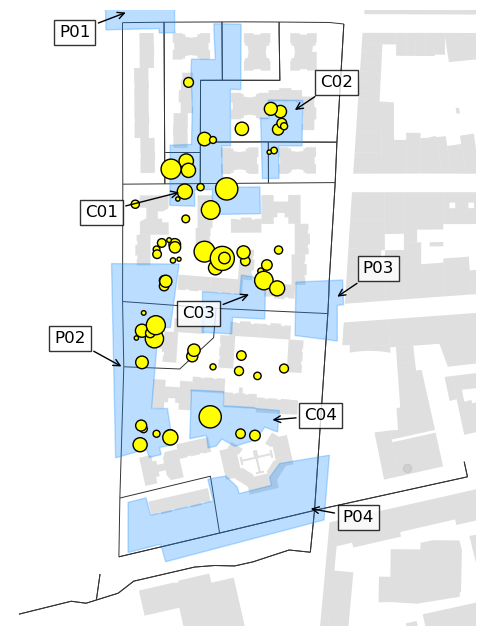

In [20]:
fig, ax = map_network2(2.2806695945859863, 41.60516612780627, 2.283855810024757,41.605231321689736,  
                       2.2839887645906876,41.60212992266021,  2.28047259104862, 41.60180046050177)  # Create the graph from a given latitude and longitude

from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature

df_tots = pd.read_csv('stops_granollers.csv')

lat_tots=df_tots['latitud'].tolist()
lon_tots=df_tots['longitud'].tolist()

    

At_cs=df_tots['durada']

max_At=max(At_cs)
new_At_cs=[]
for j in range(len(At_cs)):
    new_At_cs.append(At_cs[j]/max_At)
    
new_At_cs2=[]
for i in range(len(new_At_cs)):
    new_At_cs2.append(300*new_At_cs[i])
    
print('ALL GRUPS:')
print('')
print('Total number of stops:', len(At_cs))
print('Total stopping time:', sum(At_cs),'s')
mean_t_stop_all=np.mean(At_cs)
std_t_stop_all=np.std(At_cs)
error_t_stop_all=std_t_stop_all/np.sqrt(len(At_cs))
print('Mean stopping time:', mean_t_stop_all ,'+-',error_t_stop_all, ' ', 'std:',std_t_stop_all)
print('Shortest stopping time:', min(At_cs))
print('Longest stopping time:', max(At_cs))
print('q1={}, q2={}, q3={}'.format(np.quantile(At_cs,0.25), np.quantile(At_cs,0.5), np.quantile(At_cs,0.75)))
#print('Tots els temps:', At_cs)
print('')
print('')
print('####################################################')
print('')
print('')
print('Opportunity Units (OU)')
print('')
    
p01=Polygon([[(2.281903, 41.6047224), (2.2819017, 41.6049109), (2.2817113, 41.6049139), (2.2817193, 41.6054674),
       (2.281439, 41.6054674), (2.2814618, 41.6047274), (2.2818038, 41.6047334), (2.2818038, 41.6047123), 
       (2.2819071, 41.6047143), (2.281903, 41.6047224),]])


c01=Polygon([[(2.2821551, 41.6047224), (2.2821638, 41.6045846), (2.2820109, 41.6045866), (2.2820083, 41.6045224), 
       (2.2820163, 41.6043559), (2.2820109, 41.6041774), (2.2818741, 41.6041734), (2.2818715, 41.6038846),
       (2.2820324, 41.6038806), (2.2820297, 41.6039588), (2.2821451, 41.6039608), (2.2821451, 41.6038405), 
       (2.2824535, 41.6038445), (2.2824497, 41.603973), (2.2822096, 41.603971), (2.2822092, 41.6040323), 
       (2.2822058, 41.6041707), (2.2822615, 41.6041702), (2.2822604, 41.6044421), (2.2823274, 41.6044406), 
       (2.2823294, 41.604755), (2.2821551, 41.6047565), (2.2821551, 41.6047224),]])

c02=Polygon([[(2.2824656, 41.6040279), (2.2824669, 41.6040134), (2.2825729, 41.6040139), (2.2825702, 41.6041703),
       (2.2827204, 41.6041703), (2.2827258, 41.6043889), (2.2825032, 41.6043909), (2.2825085, 41.6043027),
       (2.2824549, 41.6043047), (2.2824656, 41.6040279),]])

p02=Polygon([[(2.2815208, 41.6036047), (2.2814974, 41.6036052), (2.2815235, 41.6026721), (2.2816362, 41.6026962), 
       (2.281722, 41.6027122), (2.2817408, 41.6026741), (2.2818159, 41.6026881), (2.2818051, 41.6027222), 
       (2.2818936, 41.6027343), (2.2818561, 41.6029088), (2.2817542, 41.6029088), (2.2817998, 41.6032999),
       (2.2818749, 41.6032979), (2.2819312, 41.6036027), (2.2815208, 41.6036047),]])

c04=Polygon([[(2.2820103, 41.6029885), (2.2819996, 41.6027639), (2.2821069, 41.6027799), (2.2821176, 41.6027198), 
       (2.2821688, 41.6027284), (2.2822063, 41.6027625), (2.2822895, 41.6027274), (2.282321, 41.6027349), 
       (2.2823364, 41.6027384), (2.2823585, 41.6027439), (2.2823773, 41.6027475), (2.2824001, 41.6027525), 
       (2.2824222, 41.6027585), (2.2824812, 41.6028196), (2.282563, 41.6027966), (2.2825751, 41.6028989), 
       (2.2824263, 41.6029089), (2.2824102, 41.6029139), (2.2822157, 41.6029219), (2.2822197, 41.6029901),
       (2.2820065, 41.6029981), (2.2820103, 41.6029885),]])

p04=Polygon([[(2.2828616, 41.6023738), (2.2828965, 41.6026847), (2.2825773, 41.6026446), (2.282513, 41.6025784), 
       (2.2825237, 41.6025403), (2.2823172, 41.6025002), (2.2823037, 41.6025322), (2.2822313, 41.6025844),
       (2.2821643, 41.6025764), (2.282116, 41.6025683), (2.2821509, 41.6024641), (2.2817485, 41.6023959), 
       (2.281719, 41.6024801), (2.2816037, 41.602458), (2.2816037, 41.6022174), (2.2818129, 41.6022575), 
       (2.2818451, 41.6021732), (2.2828616, 41.6023738),]])


p03_new=Polygon([[(2.2826815, 41.603516), (2.2826762, 41.6032593), (2.2829471, 41.6032332), (2.2829471, 41.6034037), 
                  (2.2829873, 41.6034077), (2.282982, 41.6035261), (2.2826815, 41.603516),]])


p03=Polygon([[(2.2826815, 41.603516), (2.2826762, 41.6032593), (2.2827566, 41.6032533), (2.2827432, 41.6030928), 
       (2.2826279, 41.6031009), (2.2826333, 41.6032533), (2.2823007, 41.6032633), (2.2822899, 41.6030006),
       (2.282644, 41.6029805), (2.2826413, 41.6029645), (2.28288, 41.6029565), (2.2829015, 41.6032312),
       (2.2829471, 41.6032332), (2.2829471, 41.6034037), (2.2829873, 41.6034077), (2.282982, 41.6035261),
       (2.2826815, 41.603516),]])

c03 = Polygon([[(2.2820791, 41.603275), (2.2822694, 41.6032674), (2.2822747, 41.6033467), (2.2824813, 41.6033386), 
                (2.2824868, 41.6035317), (2.2823312, 41.6035497), (2.2823205, 41.6034575), (2.2820818, 41.6034695), 
                (2.2820791, 41.603275),]])


x_c03 = [2.2820791, 2.2822694, 2.2822747, 2.2824813, 2.2824868, 2.2823312, 2.2823205, 2.2820818, 2.2820791]
y_c03 = [41.603275, 41.6032674, 41.6033467, 41.6033386, 41.6035317, 41.6035497, 41.6034575, 41.6034695, 41.603275]


x_p01=[2.281903,2.2819017,2.2817113,2.2817193,2.281439,2.2814618,2.2818038,2.2818038,2.2819071,2.281903]
y_p01=[41.6047224,41.6049109, 41.6049139, 41.6054674, 41.6054674, 41.6047274, 41.6047334, 41.6047123, 41.6047143, 41.6047224]

x_c01=[2.2821551,2.2821638,2.2820109,2.2820083,2.2820163,2.2820109,2.2818741,2.2818715,2.2820324,2.2820297,2.2821451,2.2821451,
       2.2824535,2.2824497,2.2822096,2.2822092,2.2822058,2.2822615,2.2822604,2.2823274,2.2823294,2.2821551,2.2821551]
y_c01=[41.6047224,41.6045846,41.6045866,41.6045224,41.6043559, 41.6041774, 41.6041734, 41.6038846, 41.6038806, 41.6039588,
       41.6039608, 41.6038405, 41.6038445, 41.603973, 41.603971, 41.6040323, 41.6041707, 41.6041702, 41.6044421, 41.6044406, 
       41.604755, 41.6047565, 41.6047224]

x_c02=[2.2824656,2.2824669,2.2825729,2.2825702,2.2827204,2.2827258,2.2825032,2.2825085,2.2824549,2.2824656]
y_c02=[41.6040279, 41.6040134, 41.6040139, 41.6041703, 41.6041703, 41.6043889, 41.6043909, 41.6043027, 41.6043047, 41.6040279]

x_p02=[2.2815208,2.2814974,2.2815235,2.2816362,2.281722,2.2817408,2.2818159,2.2818051,2.2818936,2.2818561,2.2817542,2.2817998,
       2.2818749,2.2819312, 2.2815208]
y_p02=[41.6036047, 41.6036052, 41.6026721, 41.6026962, 41.6027122, 41.6026741, 41.6026881, 41.6027222, 41.6027343, 41.6029088, 
       41.6029088, 41.6032999, 41.6032979, 41.6036027, 41.6036047]

x_c04=[2.2820103,2.2819996,2.2821069,2.2821176,2.2821688,2.2822063,2.2822895,2.282321,2.2823364,2.2823585,2.2823773,2.2824001,
       2.2824222,2.2824812,2.282563,2.2825751,2.2824263,2.2824102,2.2822157,2.2822197,2.2820065,2.2820103]
y_c04=[41.6029885, 41.6027639, 41.6027799, 41.6027198, 41.6027284, 41.6027625, 41.6027274, 41.6027349, 41.6027384, 41.6027439, 
       41.6027475, 41.6027525, 41.6027585, 41.6028196, 41.6027966, 41.6028989, 41.6029089, 41.6029139, 41.6029219, 41.6029901, 
       41.6029981, 41.6029885]

x_p04=[2.2828616,2.2828965,2.2825773,2.282513,2.2825237,2.2823172,2.2823037,2.2822313,2.2821643,2.282116,2.2821509,2.2817485,
       2.281719,2.2816037,2.2816037,2.2818129,2.2818451,2.2828616]
y_p04=[41.6023738, 41.6026847, 41.6026446, 41.6025784, 41.6025403, 41.6025002, 41.6025322, 41.6025844, 41.6025764, 41.6025683, 
       41.6024641, 41.6023959, 41.6024801, 41.602458, 41.6022174, 41.6022575, 41.6021732, 41.6023738]

x_p03=[2.2826815,2.2826762,2.2827566,2.2827432,2.2826279,2.2826333,2.2823007,2.2822899,2.282644,2.2826413,2.28288,2.2829015,
       2.2829471,2.2829471,2.2829873,2.282982,2.2826815]
y_p03=[41.603516, 41.6032593, 41.6032533, 41.6030928, 41.6031009, 41.6032533, 41.6032633, 41.6030006, 41.6029805, 41.6029645, 
       41.6029565, 41.6032312, 41.6032332, 41.6034037, 41.6034077, 41.6035261, 41.603516]

x_p03_new = [2.2826815, 2.2826762, 2.2829471, 2.2829471, 2.2829873, 2.282982,2.2826815 ]
y_p03_new = [41.603516, 41.6032593, 41.6032332, 41.6034037, 41.6034077, 41.6035261, 41.603516]
    
    
plt.fill(x_p01,y_p01,alpha=0.3,c='dodgerblue')
plt.fill(x_c01,y_c01,alpha=0.3,c='dodgerblue')
plt.fill(x_c02,y_c02,alpha=0.3,c='dodgerblue')
plt.fill(x_p02,y_p02,alpha=0.3,c='dodgerblue')
plt.fill(x_c04,y_c04,alpha=0.3,c='dodgerblue')
plt.fill(x_p04,y_p04,alpha=0.3,c='dodgerblue')
#plt.fill(x_p03,y_p03,alpha=0.3,c='dodgerblue') 
plt.fill(x_p03_new,y_p03_new,alpha=0.3,c='dodgerblue') 
plt.fill(x_c03,y_c03,alpha=0.3,c='dodgerblue') 

    
At_cs_inside_p01=[]
lon_stop_inside_p01=[]
lat_stop_inside_p01=[]
At_cs_inside_c01=[]
lon_stop_inside_c01=[]
lat_stop_inside_c01=[]
At_cs_inside_c02=[]
lon_stop_inside_c02=[]
lat_stop_inside_c02=[]
At_cs_inside_p02=[]
lon_stop_inside_p02=[]
lat_stop_inside_p02=[]
At_cs_inside_c04=[]
lon_stop_inside_c04=[]
lat_stop_inside_c04=[]
At_cs_inside_p04=[]
lon_stop_inside_p04=[]
lat_stop_inside_p04=[]
At_cs_inside_p03=[]
lon_stop_inside_p03=[]
lat_stop_inside_p03=[]
At_cs_inside_c03=[]
lon_stop_inside_c03=[]
lat_stop_inside_c03=[]

tags_cels=[]

for i in range(len(lon_tots)):

    point_p01 = Feature(geometry=Point((lon_tots[i],lat_tots[i])))
    point_c01 = Feature(geometry=Point((lon_tots[i],lat_tots[i])))
    point_c02 = Feature(geometry=Point((lon_tots[i],lat_tots[i])))
    point_p02 = Feature(geometry=Point((lon_tots[i],lat_tots[i])))
    point_c04 = Feature(geometry=Point((lon_tots[i],lat_tots[i])))
    point_p04 = Feature(geometry=Point((lon_tots[i],lat_tots[i])))
    point_p03 = Feature(geometry=Point((lon_tots[i],lat_tots[i])))
    point_c03 = Feature(geometry=Point((lon_tots[i],lat_tots[i])))
    
    check_p01=boolean_point_in_polygon(point_p01, p01)
    check_c01=boolean_point_in_polygon(point_c01, c01)
    check_c02=boolean_point_in_polygon(point_c02, c02)
    check_p02=boolean_point_in_polygon(point_p02, p02)
    check_c04=boolean_point_in_polygon(point_c04, c04)
    check_p04=boolean_point_in_polygon(point_p04, p04)
    check_p03=boolean_point_in_polygon(point_p03, p03_new)
    check_c03=boolean_point_in_polygon(point_c03, c03)
    
    if check_p01==True:
        lon_stop_inside_p01.append(lon_tots[i])
        lat_stop_inside_p01.append(lat_tots[i])
        At_cs_inside_p01.append(At_cs[i])
        tags_cels.append('p01')
    
    if check_c01==True:
        lon_stop_inside_c01.append(lon_tots[i])
        lat_stop_inside_c01.append(lat_tots[i])
        At_cs_inside_c01.append(At_cs[i])
        tags_cels.append('c01')
        
    if check_c02==True:
        lon_stop_inside_c02.append(lon_tots[i])
        lat_stop_inside_c02.append(lat_tots[i])
        At_cs_inside_c02.append(At_cs[i])
        tags_cels.append('c02')
        
    if check_p02==True:
        lon_stop_inside_p02.append(lon_tots[i])
        lat_stop_inside_p02.append(lat_tots[i])
        At_cs_inside_p02.append(At_cs[i])
        tags_cels.append('p02')
        
    if check_c04==True:
        lon_stop_inside_c04.append(lon_tots[i])
        lat_stop_inside_c04.append(lat_tots[i])
        At_cs_inside_c04.append(At_cs[i])
        tags_cels.append('c04')
        
    if check_p04==True:
        lon_stop_inside_p04.append(lon_tots[i])
        lat_stop_inside_p04.append(lat_tots[i])
        At_cs_inside_p04.append(At_cs[i])
        tags_cels.append('p04')
        
    if check_p03==True:
        lon_stop_inside_p03.append(lon_tots[i])
        lat_stop_inside_p03.append(lat_tots[i])
        At_cs_inside_p03.append(At_cs[i])
        tags_cels.append('p03')
        
    if check_c03==True:
        lon_stop_inside_c03.append(lon_tots[i])
        lat_stop_inside_c03.append(lat_tots[i])
        At_cs_inside_c03.append(At_cs[i])
        tags_cels.append('c03')
        
 
    if check_p01==False and check_c01==False and check_c02==False and check_p02==False and check_c04==False and check_p04==False and check_p03==False and check_c03==False:
        tags_cels.append('none')
        


print('p01:')
print('')
print('number of stops at OU p01:', len(At_cs_inside_p01))
print('total stopping time at OU p01:', sum(At_cs_inside_p01),'s' )
print('duration of each stop at OU p01', At_cs_inside_p01,'s')

if len(At_cs_inside_p01)!=0:
    mean_p01=sum(At_cs_inside_p01)/len(At_cs_inside_p01)
    max_p01=max(At_cs_inside_p01)
    min_p01=min(At_cs_inside_p01)
    print('Shortest stopping time:', min(At_cs_inside_p01))
    print('Longest stopping time:', max(At_cs_inside_p01))
else:
    mean_p01=0
    max_p01=0
    min_p01=0
print('')
print('-------------------------------------------------------------------------')
print('')
print('')

print('c01:')
print('')
print('number of stops at OU c01:', len(At_cs_inside_c01))
print('total stopping time at OU c01:', sum(At_cs_inside_c01),'s' )
print('duration of each stop at OU c01', At_cs_inside_c01,'s')
if len(At_cs_inside_c01)!=0:
    mean_c01=sum(At_cs_inside_c01)/len(At_cs_inside_c01)
    max_c01=max(At_cs_inside_c01)
    min_c01=min(At_cs_inside_c01)
    print('Shortest stopping time:', min(At_cs_inside_c01))
    print('Longest stopping time:', max(At_cs_inside_c01))
else:
    mean_c01=0
    max_c01=0
    min_c01=0
print('')
print('-------------------------------------------------------------------------')
print('')
print('')

print('c02:')
print('')
print('number of stops at OUó¡ c02:', len(At_cs_inside_c02))
print('total stopping time at OU c02:', sum(At_cs_inside_c02),'s' )
print('duration of each stop at OU c02', At_cs_inside_c02,'s')
if len(At_cs_inside_c02)!=0:
    mean_c02=sum(At_cs_inside_c02)/len(At_cs_inside_c02)
    max_c02=max(At_cs_inside_c02)
    min_c02=min(At_cs_inside_c02)
    print('Shortest stopping time:', min(At_cs_inside_c02))
    print('Longest stopping time:', max(At_cs_inside_c02))
else:
    mean_c02=0
    max_c02=0
    min_c02=0
print('')
print('-------------------------------------------------------------------------')
print('')
print('')

print('p02:')
print('')
print('number of stops at OU p02:', len(At_cs_inside_p02))
print('total stopping time at OU p02:', sum(At_cs_inside_p02),'s' )
print('duration of each stop at OU p02', At_cs_inside_p02,'s')
if len(At_cs_inside_p02)!=0:
    mean_p02=sum(At_cs_inside_p02)/len(At_cs_inside_p02)
    max_p02=max(At_cs_inside_p02)
    min_p02=min(At_cs_inside_p02)
    print('Shortest stopping time:', min(At_cs_inside_p02))
    print('Longest stopping time:', max(At_cs_inside_p02))
else:
    mean_p02=0
    max_p02=0
    min_p02=0
print('')
print('-------------------------------------------------------------------------')
print('')
print('')

print('c04:')
print('')
print('number of stops at OU c04:', len(At_cs_inside_c04))
print('total stopping time at OU c04:', sum(At_cs_inside_c04),'s' )
print('duration of each stop at OU c04', At_cs_inside_c04,'s')
if len(At_cs_inside_c04)!=0:
    mean_c04=sum(At_cs_inside_c04)/len(At_cs_inside_c04)
    max_c04=max(At_cs_inside_c04)
    min_c04=min(At_cs_inside_c04)
    print('Shortest stopping time:', min(At_cs_inside_c04))
    print('Longest stopping time:', max(At_cs_inside_c04))
else:
    mean_c04=0
    max_c04=0
    min_c04=0
print('')
print('-------------------------------------------------------------------------')
print('')
print('')

print('p04:')
print('')
print('number of stops at OU p04:', len(At_cs_inside_p04))
print('total stopping time at OU p04:', sum(At_cs_inside_p04),'s' )
print('duration of each stop at OU p04', At_cs_inside_p04,'s')
if len(At_cs_inside_p04)!=0:
    mean_p04=sum(At_cs_inside_p04)/len(At_cs_inside_p04)
    max_p04=max(At_cs_inside_p04)
    min_p04=min(At_cs_inside_p04)
    print('Shortest stopping time:', min(At_cs_inside_p04))
    print('Longest stopping time:', max(At_cs_inside_p04))
else:
    mean_p04=0
    max_p04=0
    min_p04=0
print('')
print('-------------------------------------------------------------------------')
print('')
print('')

print('p03:')
print('')
print('number of stops at OU p03:', len(At_cs_inside_p03))
print('total stopping time at OU p03:', sum(At_cs_inside_p03),'s' )
print('duration of each stop at OU p03', At_cs_inside_p03,'s')
if len(At_cs_inside_p03)!=0:
    mean_p03=sum(At_cs_inside_p03)/len(At_cs_inside_p03)
    max_p03=max(At_cs_inside_p03)
    min_p03=min(At_cs_inside_p03)
    print('Shortest stopping time:', min(At_cs_inside_p03))
    print('Longest stopping time:', max(At_cs_inside_p03))
else:
    mean_p03=0
    max_p03=0
    min_p03=0
print('')
print('-------------------------------------------------------------------------')
print('')
print('')


print('c03:')
print('')
print('number of stops at OU c03:', len(At_cs_inside_c03))
print('total stopping time at OU c03:', sum(At_cs_inside_c03),'s' )
print('duration of each stop at OU c03', At_cs_inside_c03,'s')
if len(At_cs_inside_c03)!=0:
    mean_c03=sum(At_cs_inside_c03)/len(At_cs_inside_c03)
    max_c03=max(At_cs_inside_c03)
    min_c03=min(At_cs_inside_c03)
    print('Shortest stopping time:', min(At_cs_inside_c03))
    print('Longest stopping time:', max(At_cs_inside_c03))
else:
    mean_c03=0
    max_c03=0
    min_c03=0
print('')
print('-------------------------------------------------------------------------')
print('')
print('')



num=[len(At_cs_inside_p01), len(At_cs_inside_c01), len(At_cs_inside_c02), len(At_cs_inside_p02), len(At_cs_inside_c04),
    len(At_cs_inside_p04),len(At_cs_inside_p03),len(At_cs_inside_c03)]

t=[sum(At_cs_inside_p01), sum(At_cs_inside_c01), sum(At_cs_inside_c02), sum(At_cs_inside_p02), sum(At_cs_inside_c04),
    sum(At_cs_inside_p04),sum(At_cs_inside_p03),sum(At_cs_inside_c03)]

max_t=[0, max(At_cs_inside_c01), max(At_cs_inside_c02), max(At_cs_inside_p02), max(At_cs_inside_c04),0, 0,max(At_cs_inside_c03)]

min_t=[0, min(At_cs_inside_c01),min(At_cs_inside_c02), min(At_cs_inside_p02), min(At_cs_inside_c04),0, 0,min(At_cs_inside_c03)]

mean_t=[mean_p01,mean_c01,mean_c02,mean_p02,mean_c04,mean_p04,mean_p03,mean_c03]

std_t=[0,np.std(At_cs_inside_c01),np.std(At_cs_inside_c02),np.std(At_cs_inside_p02),np.std(At_cs_inside_c04),0,0,np.std(At_cs_inside_c03)]

unitats=['p01','c01','c02','p02','c04','p04','p03','c03']


colorss=df_tots['color'].tolist()

plt.scatter(lon_tots,lat_tots,c='yellow',s=new_At_cs2, edgecolor='black')
#plt.scatter(lon_tots,lat_tots,c=colorss,s=1)


bbox_args = dict(boxstyle='square',facecolor='white', edgecolor='k',alpha=0.8)
arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='black')

plt.annotate('P01', (2.281605325618739, 41.60481509954927),c='black',size=12,
                 bbox=bbox_args,arrowprops=arrowprops, xytext=(-50, -18),textcoords='offset points')

plt.annotate('C01', (2.281949174140357, 41.60395027398868),c='black',size=12,
                 bbox=bbox_args,arrowprops=arrowprops, xytext=(-70, -18),textcoords='offset points')

plt.annotate('C02', ( 2.282659600071432, 41.604334875302996),c='black',size=12,
                 bbox=bbox_args,arrowprops=arrowprops, xytext=(20, 18),textcoords='offset points')

plt.annotate('P02', (2.2815769120967007, 41.60310456286429),c='black',size=12,
                 bbox=bbox_args,arrowprops=arrowprops, xytext=(-50, 18),textcoords='offset points')


plt.annotate('P03', (2.2829324305927323, 41.603438326385046),c='black',size=12,
                 bbox=bbox_args,arrowprops=arrowprops, xytext=(20, 18),textcoords='offset points')

plt.annotate('C04', ( 2.282512516984688,41.602852914554994),c='black',size=12,
                 bbox=bbox_args,arrowprops=arrowprops, xytext=(25, 0),textcoords='offset points')


plt.annotate('P04', ( 2.282759242393534,41.60243070462162),c='black',size=12,
                 bbox=bbox_args,arrowprops=arrowprops, xytext=(25, -10),textcoords='offset points')

plt.annotate('C03', (2.2823968769745986, 41.60346164200983),c='black',size=12,
                 bbox=bbox_args,arrowprops=arrowprops, xytext=(-50, -18),textcoords='offset points')

#plt.savefig('stops_actions_all.pdf',format='pdf', bbox_inches='tight')

plt.show()

    

In [21]:
err=[]
for i in range(len(unitats)):
    err.append(std_t[i]/np.sqrt(num[i]))

df_temps_unitats=pd.DataFrame()

df_temps_unitats['OU']=unitats
df_temps_unitats['num_stops']=num
df_temps_unitats['total_stopping_time_s']=t
df_temps_unitats['mean_stopping_time_s']=mean_t
df_temps_unitats['std_stopping_time_s']=std_t
df_temps_unitats['std_error_stopping_time_s']=err
df_temps_unitats['longest_stop_s']=max_t
df_temps_unitats['shortest_stops']=min_t

df_temps_unitats

C:\Users\josep\AppData\Local\Temp\ipykernel_14724\4087855402.py:3: RuntimeWarning: invalid value encountered in scalar divide
  err.append(std_t[i]/np.sqrt(num[i]))


,OU,num_stops,total_stopping_time_s,mean_stopping_time_s,std_stopping_time_s,std_error_stopping_time_s,longest_stop_s,shortest_stops
0,p01,0,0.0,0.000000,0.000000,NaN,0.0,0.0
1,c01,9,9904.0,1100.444444,817.833331,272.611110,2677.0,96.0
2,c02,7,3517.0,502.428571,289.650951,109.477769,909.0,100.0
3,p02,17,12739.0,749.352941,520.373615,126.209140,1955.0,100.0
4,c04,4,3805.0,951.250000,1014.108568,507.054284,2669.0,39.0
5,p04,0,0.0,0.000000,0.000000,NaN,0.0,0.0
6,p03,0,0.0,0.000000,0.000000,NaN,0.0,0.0
7,c03,1,1845.0,1845.000000,0.000000,0.000000,1845.0,1845.0


<br>

# 2. OUs vs weighted K-means clusters

We study how many stops both AOU and k-means clusters share

In [22]:
data_with_clusters_k7= pd.read_csv('weighted_kmeans_k7.csv')  # read the CLUSTERING results

In [23]:
df_tots=data_with_clusters_k7
df_tots['tags_units']=tags_cels

cluster_tag=[]
for i in range(len(df_tots)):
    if df_tots['Cluster_color'][i]=='blue':
        cluster_tag.append('AC3')
        
    elif df_tots['Cluster_color'][i]=='red':
        cluster_tag.append('AC5')
        
    elif df_tots['Cluster_color'][i]=='green':
        cluster_tag.append('AC2')
        
    elif df_tots['Cluster_color'][i]=='purple':
        cluster_tag.append('AC6')
        
    elif df_tots['Cluster_color'][i]=='yellow':
        cluster_tag.append('AC7')
        
    elif df_tots['Cluster_color'][i]=='magenta':
        cluster_tag.append('AC1')
        
    elif df_tots['Cluster_color'][i]=='orange':
        cluster_tag.append('AC4')

df_tots['Cluster_tag']=cluster_tag


### crossing OUs and Activation Clusters

In [24]:
for i,j in df_tots.groupby('tags_units'):
    print(i)
    print('')
    print('number of stops:',len(j['Duration_stop']))
    print('')
    print(j['Cluster_tag'].value_counts())
    print('')
    print('-----------')
    print('')

c01

number of stops: 9

Cluster_tag
AC3    9
Name: count, dtype: int64

-----------

c02

number of stops: 7

Cluster_tag
AC4    7
Name: count, dtype: int64

-----------

c03

number of stops: 1

Cluster_tag
AC2    1
Name: count, dtype: int64

-----------

c04

number of stops: 4

Cluster_tag
AC7    4
Name: count, dtype: int64

-----------

none

number of stops: 30

Cluster_tag
AC5    11
AC2     9
AC7     5
AC1     2
AC4     2
AC3     1
Name: count, dtype: int64

-----------

p02

number of stops: 17

Cluster_tag
AC1    8
AC6    6
AC5    3
Name: count, dtype: int64

-----------



#### statistics of all stops inside OUs

In [25]:
At_totss = At_cs_inside_p01 + At_cs_inside_p02 + At_cs_inside_p03 + At_cs_inside_p04 + At_cs_inside_c01 + At_cs_inside_c02 + At_cs_inside_c03 + At_cs_inside_c04

print('<At> = ', np.mean(At_totss))
print('std = ', np.std(At_totss))
print('error = ', np.std(At_totss)/np.sqrt(len(At_totss)))
print('min = ', min(At_totss), 'max = ', max(At_totss))

<At> =  837.1052631578947
std =  686.9283571574522
error =  111.43449431310192
min =  39.0 max =  2677.0
